<a href="https://colab.research.google.com/github/imallag/solana/blob/main/ETL_perf_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
from sqlalchemy import create_engine
import time
import re

def fetch_transactions(wallet_address, api_key, last_signature=None):
    base_url = f'https://api.helius.xyz/v0/addresses/{wallet_address}/transactions'
    params = {'api-key': api_key}
    all_transactions = []
    retries = 10

    while True:
        if last_signature:
            params['before'] = last_signature

        url = base_url
        print(f"Fetching transactions with URL: {url}, Params: {params}")  # Debugging line
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                transactions = response.json()
                if transactions:
                    all_transactions.extend(transactions)
                    print(f"Fetched {len(transactions)} transactions, total: {len(all_transactions)}")
                    last_signature = transactions[-1]['signature']
                else:
                    print("No more transactions available.")
                    break
            elif response.status_code == 400 or response.status_code == 404:
                error_msg = response.json().get('error', '')
                match = re.search(r"` parameter set to (.+)", error_msg)
                if match:
                    before_value = match.group(1).strip('. ')  # Strip trailing dot and space
                    print(f"Extracted 'before' value: {before_value}")  # Debugging line
                    last_signature = before_value
                    continue
                else:
                    print(f"Error fetching transactions: {response.status_code} - {response.text}")
                    break
            else:
                print(f"Error fetching transactions: {response.status_code} - {response.text}")
                break
        except requests.exceptions.Timeout:
            print("Request timed out. Retrying...")
            retries -= 1
            if retries == 0:
                print("Max retries reached. Exiting.")
                break
            time.sleep(5)
        except requests.exceptions.RequestException as e:
            print(f"Request failed: {e}")
            break

    return all_transactions

def transform_to_dataframe(transactions):
    data = []
    for tx in transactions:
        for transfer in tx.get('tokenTransfers', []):
            data.append({
                'wallet': tx.get('description', ''),
                'type': tx.get('type', ''),
                'source': tx.get('source', ''),
                'fee': tx.get('fee', 0),
                'feePayer': tx.get('feePayer', ''),
                'signature': tx.get('signature', ''),
                'slot': tx.get('slot', 0),
                'timestamp': tx.get('timestamp', 0),
                'fromTokenAccount': transfer.get('fromTokenAccount', ''),
                'toTokenAccount': transfer.get('toTokenAccount', ''),
                'fromUserAccount': transfer.get('fromUserAccount', ''),
                'toUserAccount': transfer.get('toUserAccount', ''),
                'tokenAmount': transfer.get('tokenAmount', 0),
                'mint': transfer.get('mint', ''),
                'tokenStandard': transfer.get('tokenStandard', '')
            })

    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    return df

def save_to_database(df, database_url, table_name):
    engine = create_engine(database_url)
    with engine.connect() as connection:
        df.to_sql(table_name, con=connection, if_exists='append', index=False)

def main():
    wallet_address = 'BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t'  # Replace with your wallet address
    api_key = 'helius_api_key'  # Replace with your API key
    database_url = 'sqlite:///transactions.db'  # Replace with your database URL
    table_name = 'transactions'

    # Fetch transactions
    transactions = fetch_transactions(wallet_address, api_key)

    # Transform to DataFrame
    df = transform_to_dataframe(transactions)

    # Save DataFrame to database
    save_to_database(df, database_url, table_name)


if __name__ == "__main__":
    main()


Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Params: {'api-key': '3f1b1b43-a6bb-40d2-8647-04cd2eee0750'}
Fetched 21 transactions, total: 21
Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Params: {'api-key': '3f1b1b43-a6bb-40d2-8647-04cd2eee0750', 'before': '5A57LbPtMdjaXhMWsBqTUusA2c9ZGLaTvNu7Xozp6CNvYiq1NF2DuLimDhLyHfCuzFmB7fGmKNg7uYVcvdmsgPpJ'}
Fetched 21 transactions, total: 42
Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Params: {'api-key': '3f1b1b43-a6bb-40d2-8647-04cd2eee0750', 'before': 'RbSErHM25Z72zHkh7dE1KY51wxipNXLge5ag3WAvcZTs7vTEw6aab5RBYGtX6DeQQczGhNihP4g4bfqzUFoTPqT'}
Fetched 21 transactions, total: 63
Fetching transactions with URL: https://api.helius.xyz/v0/addresses/BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t/transactions, Para

# Acessing the data

In [2]:
import pandas as pd
from sqlalchemy import create_engine

# Replace with your database URL
database_url = 'sqlite:///transactions.db'

# Table name in your database
table_name = 'transactions'

# Create SQLAlchemy engine
engine = create_engine(database_url)

# Load data from the database into a DataFrame
df_from_db = pd.read_sql_table(table_name, con=engine)

# Display the DataFrame
print("DataFrame loaded from the database:")
print(df_from_db.head())  # Display first few rows

DataFrame loaded from the database:
                                              wallet  type   source    fee  \
0  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...  SWAP  RAYDIUM   6124   
1  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...  SWAP  RAYDIUM   6124   
2  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...  SWAP  RAYDIUM   6141   
3  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...  SWAP  RAYDIUM   6141   
4  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...  SWAP  RAYDIUM  16122   

                                       feePayer  \
0  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
1  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
2  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
3  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   
4  BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t   

                                           signature       slot  \
0  2MSxzTHRzPMHYjtMehNS2GtmN5jrum8rYMQ3YySmy3KV4t...  279279154   
1  2MSxzTHRzPMHYjtMehNS2GtmN5jrum8rYMQ3YySmy3KV4t...  

In [3]:
bet_size = 0.002

In [4]:
wsol_trades = df_from_db[(df_from_db['mint'] == 'So11111111111111111111111111111111111111112') &
                         (df_from_db['tokenAmount'] != bet_size) & (df_from_db['type'] == 'SWAP')]

In [5]:
wsol_trades.drop(columns=['feePayer', 'fromTokenAccount', 'toTokenAccount', 'fromUserAccount', 'toUserAccount', 'mint', 'tokenStandard'], inplace=True)

<ipython-input-5-1cffe0141d49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wsol_trades.drop(columns=['feePayer', 'fromTokenAccount', 'toTokenAccount', 'fromUserAccount', 'toUserAccount', 'mint', 'tokenStandard'], inplace=True)


In [6]:
wsol_trades = wsol_trades.sort_values(by='slot', ascending=True).reset_index(drop=True)

In [7]:
wsol_trades['PnL'] = wsol_trades['tokenAmount'] - bet_size
wsol_trades['PnL %'] = (wsol_trades['PnL'] / bet_size) * 100
wsol_trades['Cumulative_pnl'] = wsol_trades['PnL'].cumsum()

In [16]:
wsol_trades

,wallet,type,source,fee,signature,slot,timestamp,tokenAmount,PnL,PnL %,Cumulative_pnl
0,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,15140,2HfWvpYFPWcahJCa3mkrTSgAZa1RcxYUHYV7MeH5Q6118n...,278482195,2024-07-19 17:49:53,0.001962,-0.000038,-1.91180,-0.000038
1,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,15140,2HfWvpYFPWcahJCa3mkrTSgAZa1RcxYUHYV7MeH5Q6118n...,278482195,2024-07-19 17:49:53,0.001962,-0.000038,-1.91180,-0.000076
2,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,15097,62H9om9oCBYijyNWA6tGeTEoAWmFMamT2aLzL28tHcHhNQ...,278485116,2024-07-19 18:10:46,0.001933,-0.000067,-3.32945,-0.000143
3,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,15097,62H9om9oCBYijyNWA6tGeTEoAWmFMamT2aLzL28tHcHhNQ...,278485116,2024-07-19 18:10:46,0.001933,-0.000067,-3.32945,-0.000210
4,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,15138,5WAU5AXzLXyuFowPbRa6wyYo6V6ojKA6qVviGEw1feFTVy...,278506876,2024-07-19 20:52:22,0.001793,-0.000207,-10.33110,-0.000416
...,...,...,...,...,...,...,...,...,...,...,...
85,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,6200,4jpwoHkK92h7ba5pMJUWfWLi1wkhTVYS9MRhZaetNyhZAi...,279269357,2024-07-23 20:07:15,0.001974,-0.000026,-1.27695,0.003707
86,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,6141,4ST6pBBdzZf5jJYiWj2m1cnavJ4fLSB63iB1HDfTkddt9h...,279278808,2024-07-23 21:18:14,0.001639,-0.000361,-18.03190,0.003346
87,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,6141,4ST6pBBdzZf5jJYiWj2m1cnavJ4fLSB63iB1HDfTkddt9h...,279278808,2024-07-23 21:18:14,0.001639,-0.000361,-18.03190,0.002986
88,BfwRPhWViYr5rK8JPQVDEFvRqbyUowU2MiBJgbJEKc4t s...,SWAP,RAYDIUM,6124,2MSxzTHRzPMHYjtMehNS2GtmN5jrum8rYMQ3YySmy3KV4t...,279279154,2024-07-23 21:20:49,0.001872,-0.000128,-6.42395,0.002857


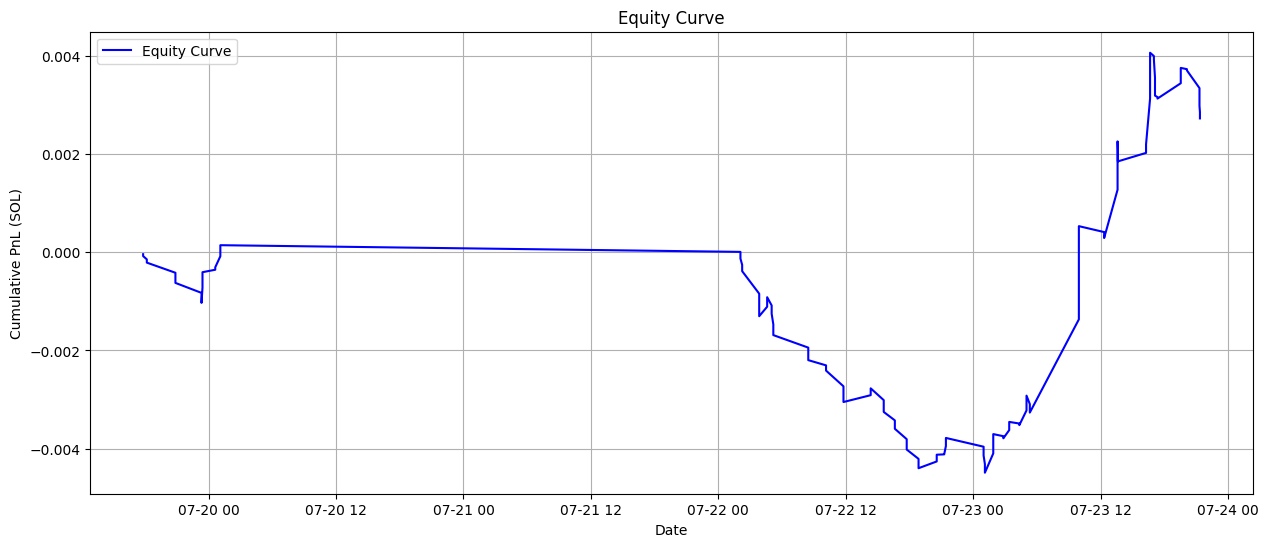

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 6))
plt.plot(wsol_trades['timestamp'], wsol_trades['Cumulative_pnl'], label='Equity Curve', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL (SOL)')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.show()

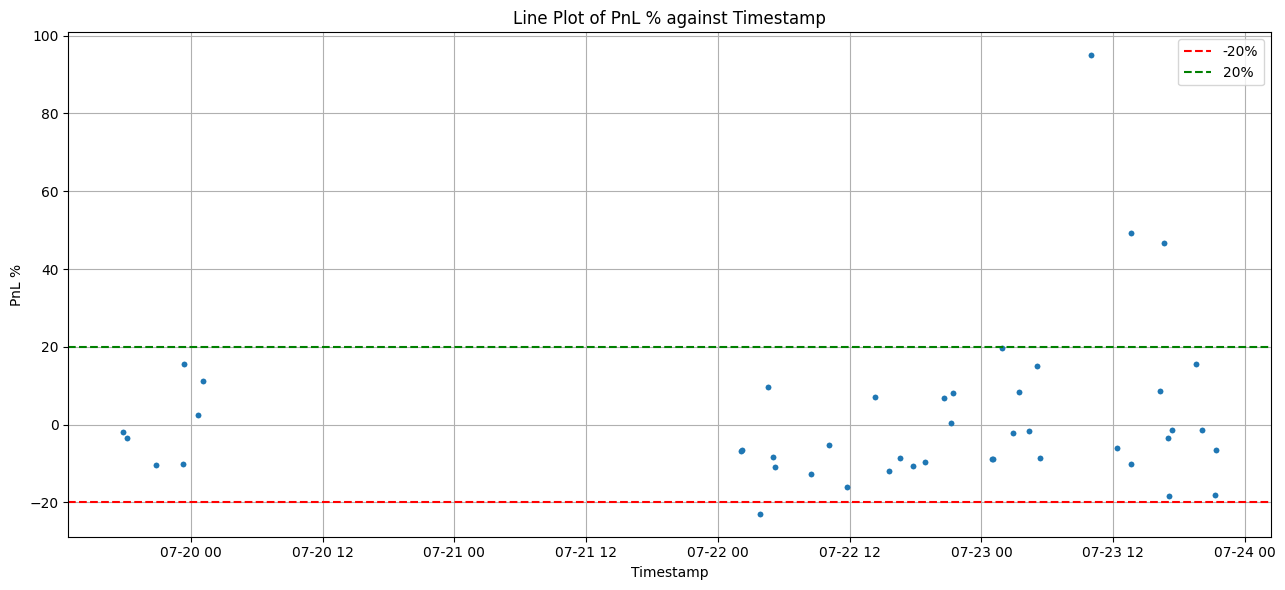

In [10]:
plt.figure(figsize=(13, 6))
plt.plot(wsol_trades['timestamp'], wsol_trades['PnL %'], marker='o',  markersize=3, linestyle='')
plt.axhline(y=-20, color='red', linestyle='--', label='-20%')
plt.axhline(y=20, color='green', linestyle='--', label='20%')
plt.title('Line Plot of PnL % against Timestamp')
plt.xlabel('Timestamp')
plt.ylabel('PnL %')
plt.legend()
plt.grid(True)
plt.tight_layout()

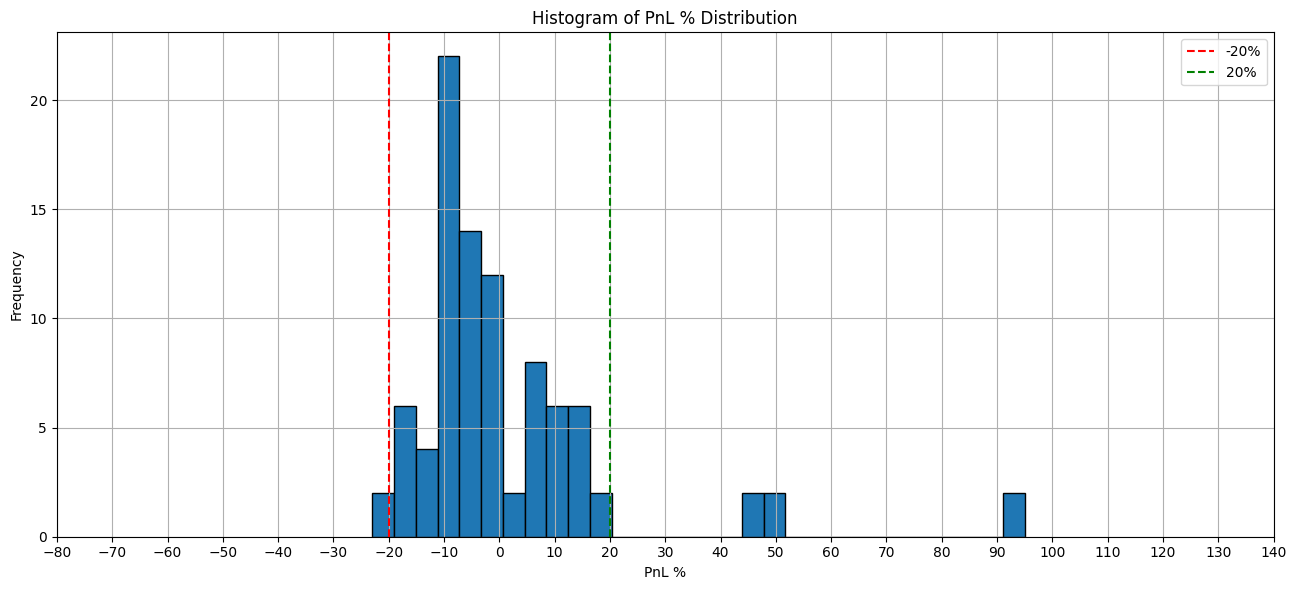

In [11]:
plt.figure(figsize=(13, 6))
plt.hist(wsol_trades['PnL %'], bins=30, edgecolor='black')
plt.axvline(x=-20, color='red', linestyle='--', label='-20%')
plt.axvline(x=20, color='green', linestyle='--', label='20%')
plt.title('Histogram of PnL % Distribution')
plt.xlabel('PnL %')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Set specific values on x-axis
plt.xticks(range(-80, 150, 10))  # Adjust range and step as needed

plt.show()

<ipython-input-12-bab48f077a07>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(wsol_trades['PnL %'], shade=True, color='b', label='Density')


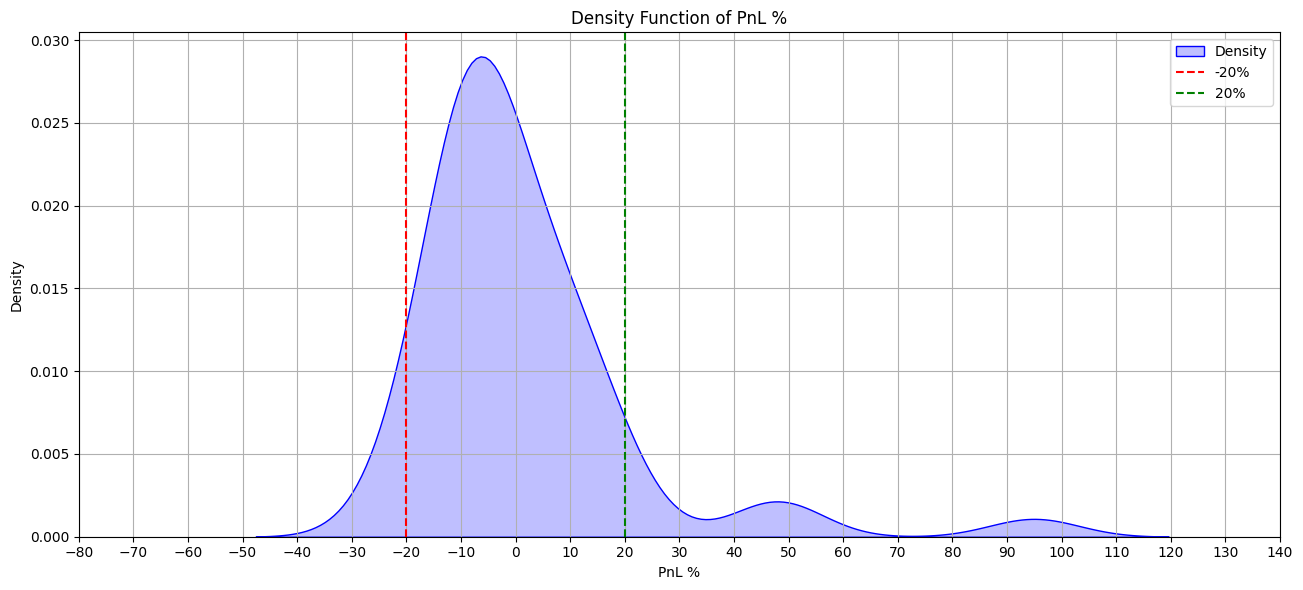

In [12]:
import seaborn as sns

plt.figure(figsize=(13, 6))
sns.kdeplot(wsol_trades['PnL %'], shade=True, color='b', label='Density')
plt.axvline(x=-20, color='red', linestyle='--', label='-20%')
plt.axvline(x=20, color='green', linestyle='--', label='20%')
plt.title('Density Function of PnL %')
plt.xlabel('PnL %')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(range(-80, 150, 10))

plt.show()

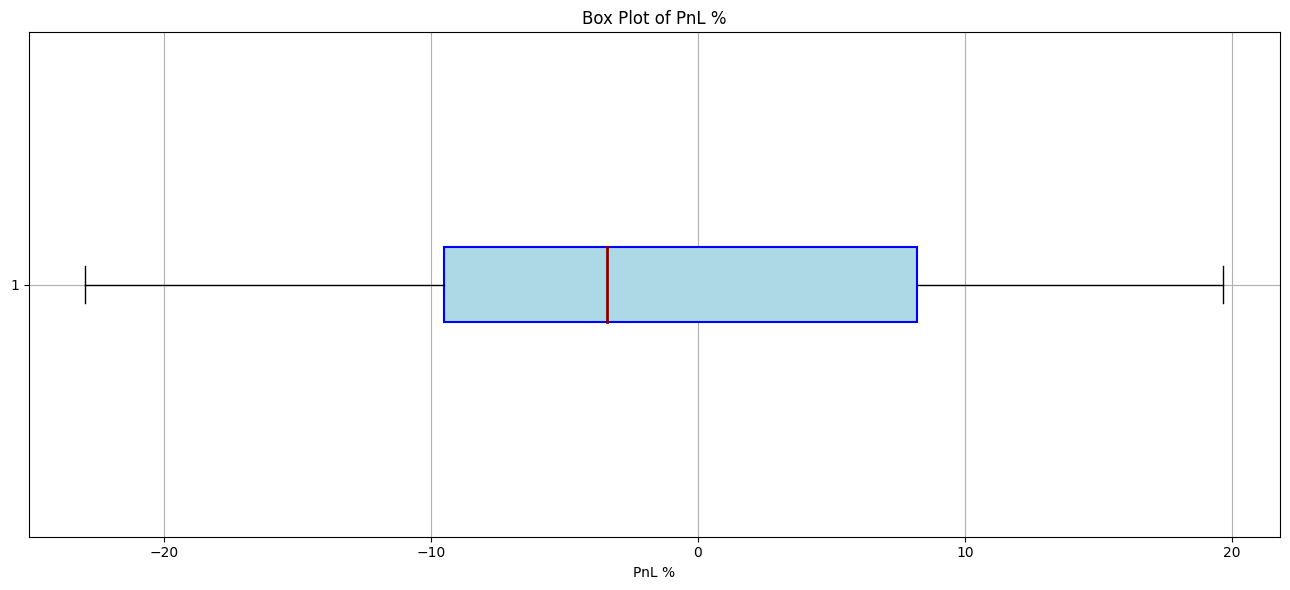

In [13]:
plt.figure(figsize=(13, 6))
boxprops = dict(facecolor='lightblue', color='blue', linewidth=1.5)
medianprops = dict(color='darkred', linewidth=2)
meanprops = dict(marker='o', markeredgecolor='black', markerfacecolor='firebrick')
plt.boxplot(wsol_trades['PnL %'], vert=False, patch_artist=True, showfliers=False,
            boxprops=boxprops, medianprops=medianprops, meanprops=meanprops)

plt.title('Box Plot of PnL %')
plt.xlabel('PnL %')
plt.grid(True)
plt.tight_layout()

plt.show()

In [14]:
# Compute statistical metrics including 10th and 90th percentiles
median = wsol_trades['PnL %'].median()
volatility = wsol_trades['PnL %'].std()
mean = wsol_trades['PnL %'].mean()
minimum = wsol_trades['PnL %'].min()
maximum = wsol_trades['PnL %'].max()
percentiles = wsol_trades['PnL %'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])  # Including 10th and 90th percentiles

# Display results
print(f"Median: {median:.2f}")
print(f"Volatility (Standard Deviation): {volatility:.2f}")
print(f"Mean: {mean:.2f}")
print(f"Minimum: {minimum:.2f}")
print(f"Maximum: {maximum:.2f}")
print(f"10th Percentile: {percentiles[0.1]:.2f}")
print(f"25th Percentile: {percentiles[0.25]:.2f}")
print(f"50th Percentile (Median): {percentiles[0.5]:.2f}")
print(f"75th Percentile: {percentiles[0.75]:.2f}")
print(f"90th Percentile: {percentiles[0.9]:.2f}")

Median: -3.40
Volatility (Standard Deviation): 20.20
Mean: 1.52
Minimum: -22.95
Maximum: 94.97
10th Percentile: -12.76
25th Percentile: -9.50
50th Percentile (Median): -3.40
75th Percentile: 8.20
90th Percentile: 15.64


In [15]:
total_pnl = wsol_trades['PnL'].sum()
print(f"Total PnL (SOL): {total_pnl}")


Total PnL (SOL): 0.002728661999999997
